In [265]:
import os
from os.path import join, basename
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [343]:
def mask_color_img(img, mask, color=[255, 0, 0], alpha=0.3):
    out = img.copy()
    img_layer = img.copy()
    img_layer[mask.astype(np.bool)] = color
    out = cv2.addWeighted(img_layer, alpha, out, 1 - alpha, 0, out)
    return(out)

In [276]:
def simple_segement(image):
    
    kernel = np.ones(9).reshape((3, 3))

    edges = cv2.Canny(image, 15, 50)    
    dilation = cv2.dilate(edges, kernel, iterations = 2)
    opening = cv2.morphologyEx(dilation, cv2.MORPH_OPEN, kernel, iterations = 2)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
    erosion = cv2.erode(closing, kernel, iterations = 1)
    
    return erosion

In [277]:
def get_confluency(mask):
    bool_mask = mask.astype(np.bool)
    total = len(bool_mask.flatten())
    foreground = np.sum(bool_mask)
    return foreground/total

In [278]:
def min_max_norm(x, new_max=1):   
    x_np = np.array(x)
    x_max = np.max(x_np)
    x_min = np.min(x_np)
    x_np = x_np - x_min
    max_diff = x_max - x_min
    return x_np / max_diff

In [279]:
def arbitary_min_max_norm(x, tmax, tmin=0):
    x_np = np.array(x)
    rmin = np.min(x_np)
    rmax = np.max(x_np)
    r_diff = rmax - rmin
    t_diff = tmax - tmin
    x_np = x_np - rmin
    x_np = x_np / r_diff
    return x_np * t_diff + tmin

In [318]:
def get_image_stats(path, normalize=True, image_type=".png"):
    """
    Returns image confluency and standard deviation for every image in path.
    
    :param path: Path to image directory
    :param normalize: Normalize images to confluence min/max
    :param image_type: Type of images in path
    :return:
    """
    
    confluencys = []
    stds = []

    for img_path in glob(join(path, f"*{image_type}")):
        
        if "20200203_3T3_Hoechst_Pos3" in dir_name and basename(img_path) == "Stack0057.png":
            print("Skipped:", join(image_dir, img_path))
            continue
        
        image = cv2.imread(img_path)

        stds.append(np.std(image))

        segmented = simple_segement(image).astype(np.bool)
        confluency = np.round(get_confluency(segmented), 4)*100
        confluencys.append(confluency)
    
    confluencys = np.array(confluencys)
    stds = np.array(stds)
    
    if len(confluencys) == 0 or len(stds) == 0:
        return confluencys, stds

    if normalize:
        conf_max = np.max(confluencys)
        conf_min = np.min(confluencys)
        confluencys = arbitary_min_max_norm(confluencys, conf_max, conf_min)
        stds = arbitary_min_max_norm(stds, conf_max, conf_min)
    
    return confluencys, stds

In [311]:
BASE_DIRS = glob("D:\\Nabil_object_detection\\train\\data\\*")
BASE_DIRS = [join(d, "10x") for d in BASE_DIRS]
BASE_DIRS.append("D:\\Nabil_object_detection\\val\\20200204_NRK_Hoechst_Pos7\\10x")

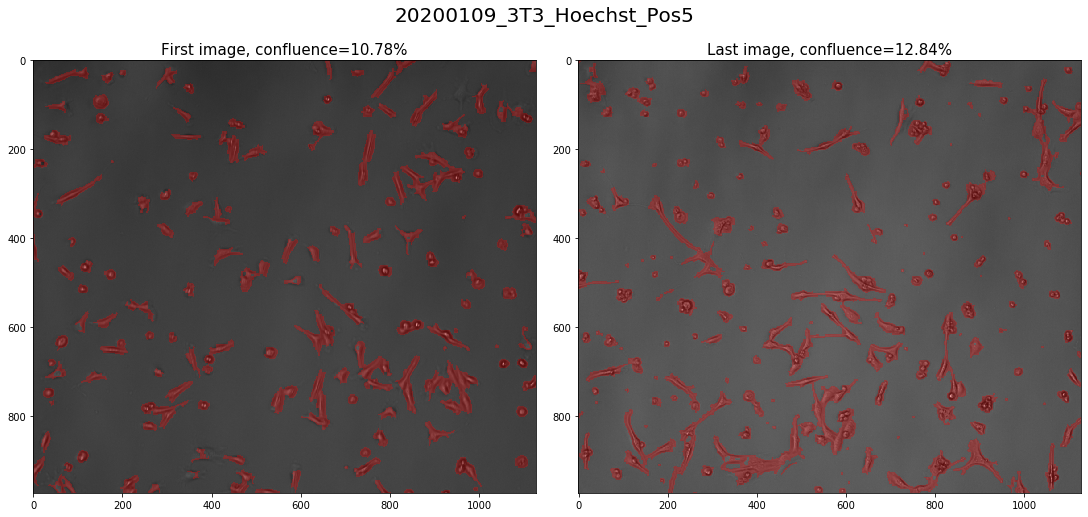

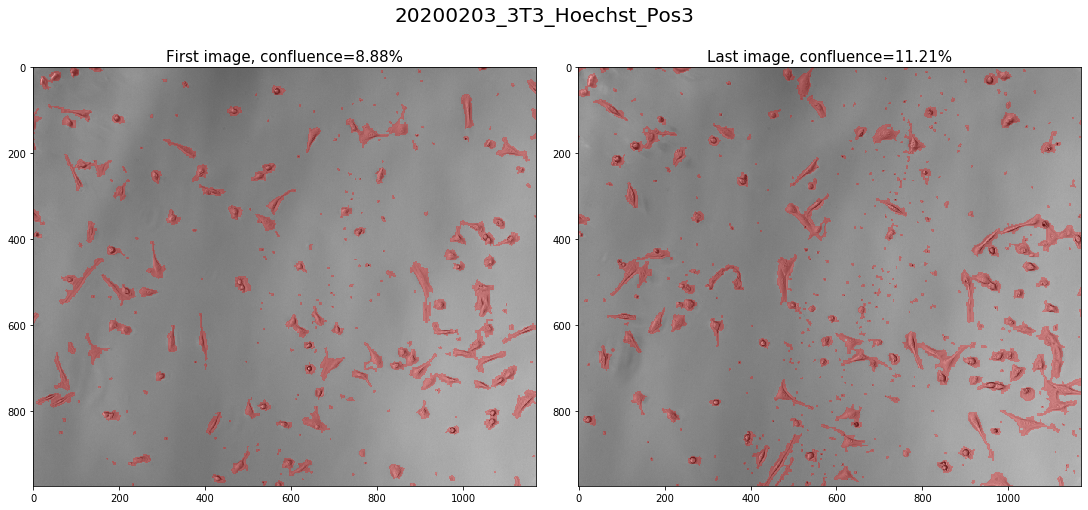

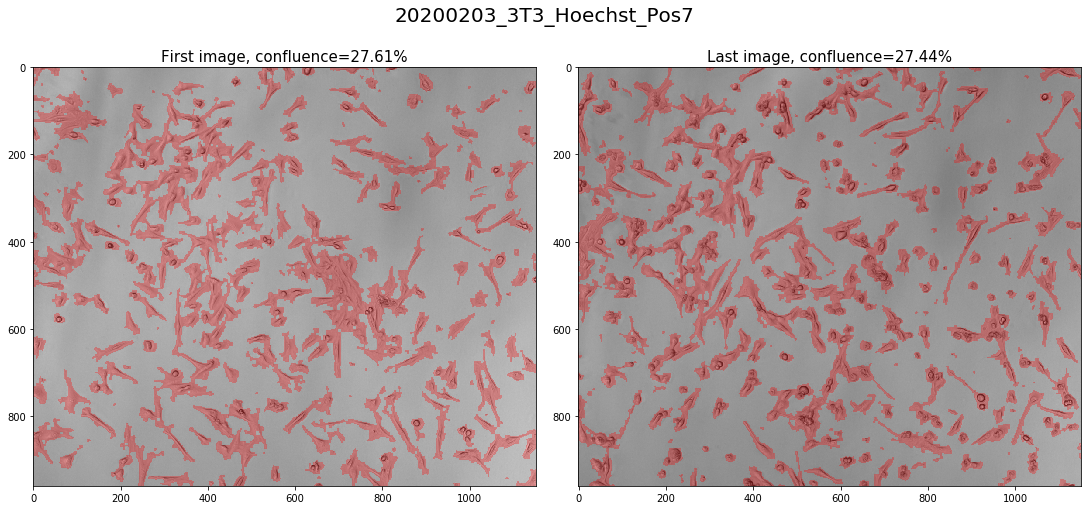

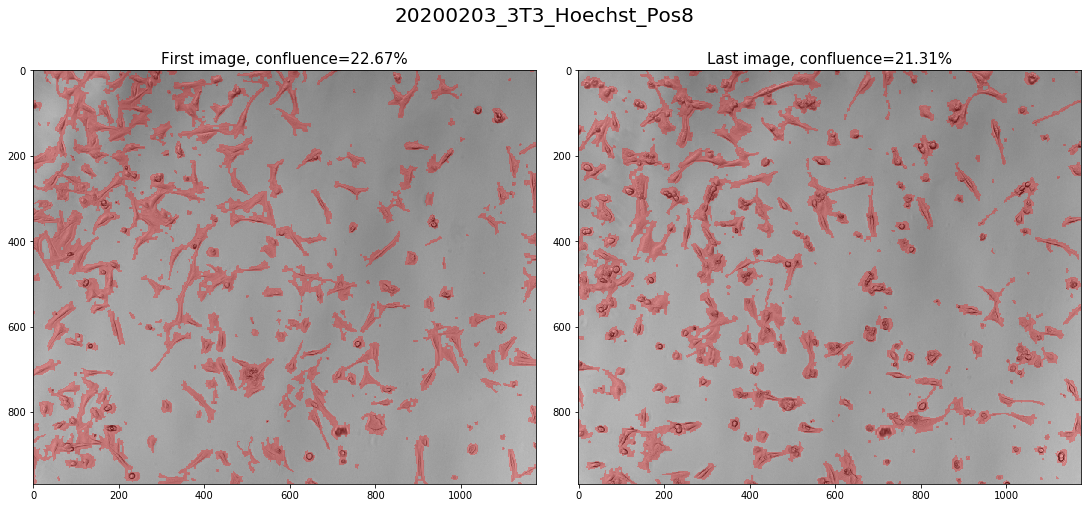

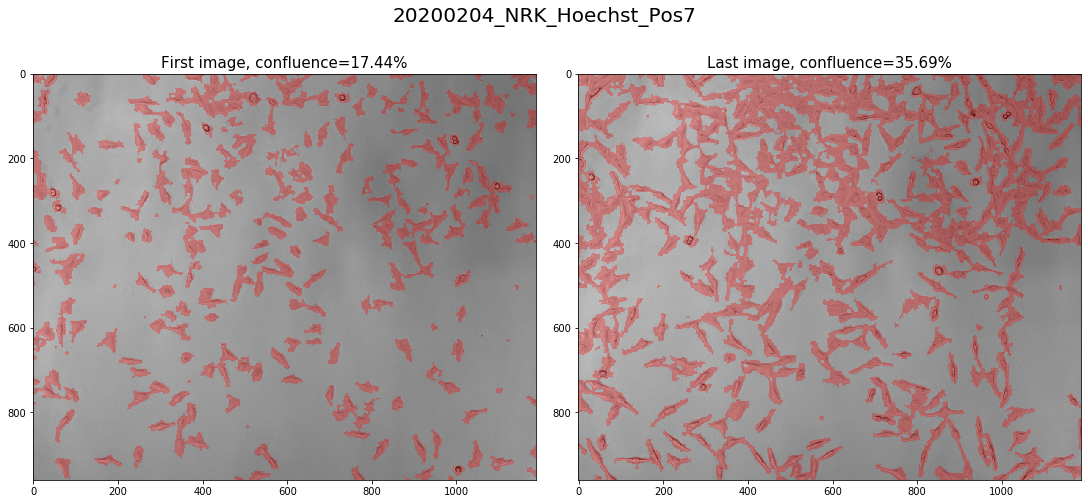

In [360]:
for image_dir in BASE_DIRS:
    image_paths = glob(join(image_dir, "*.png"))
    
    first_image, last_image = cv2.imread(image_paths[0]), cv2.imread(image_paths[-1])
    first_segments, last_segments = simple_segement(first_image), simple_segement(last_image)
    first_masked, last_masked = mask_color_img(first_image, first_segments), mask_color_img(last_image, last_segments)
    
    fist_conf, last_conf = get_confluency(first_segments)*100, get_confluency(last_segments)*100
    
    dir_name = image_dir.split("\\")[-2]
    
    fig, axs = plt.subplots(1, 2, constrained_layout=True)
    fig.suptitle(f"{dir_name}", fontsize=20, y=0.75)
    fig.set_size_inches((15,15))
    
    axs[0].set_title(f"First image, confluence={fist_conf:.2f}%", fontsize=15)
    axs[0].imshow(first_masked, cmap="gray")
    axs[1].set_title(f"Last image, confluence={last_conf:.2f}%", fontsize=15)
    axs[1].imshow(last_masked, cmap="gray")
    
    fig.set_tight_layout(False)
    plt.show()

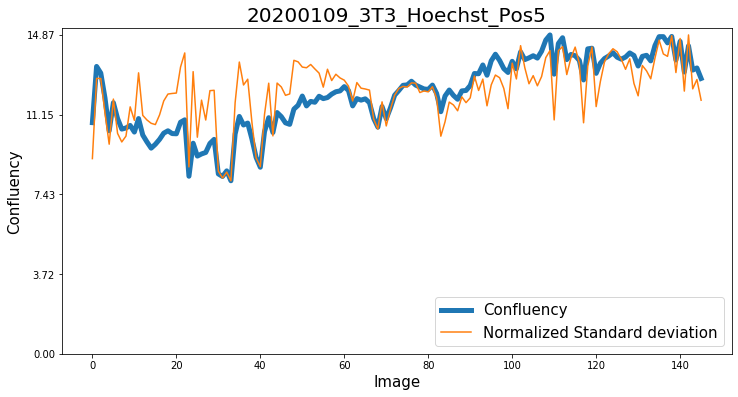

Skipped: D:\Nabil_object_detection\train\data\20200203_3T3_Hoechst_Pos3\10x\Stack0057.png


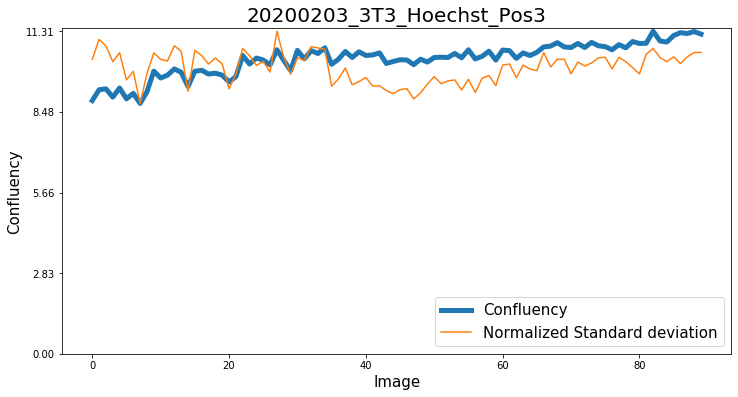

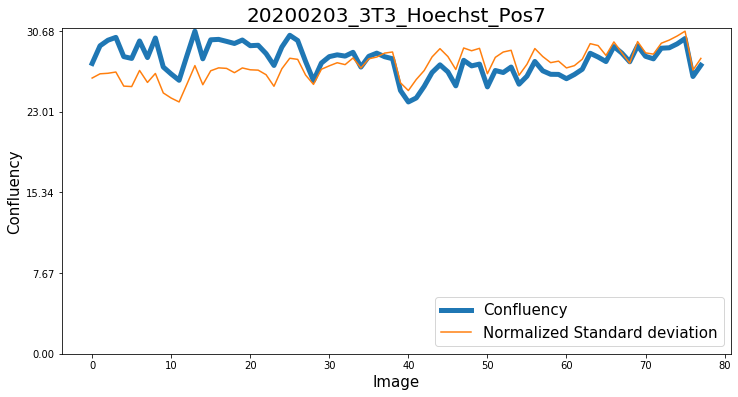

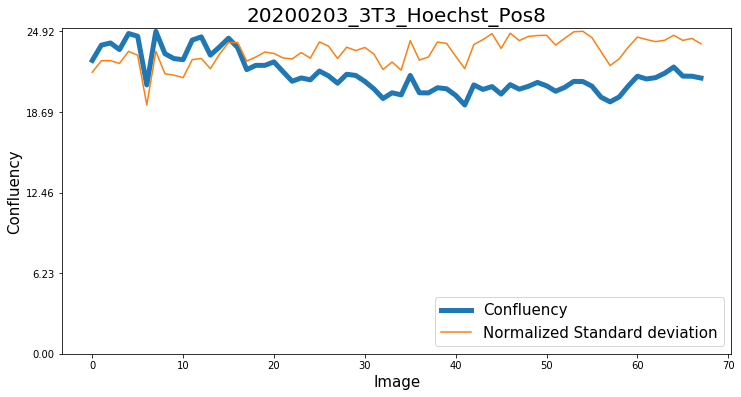

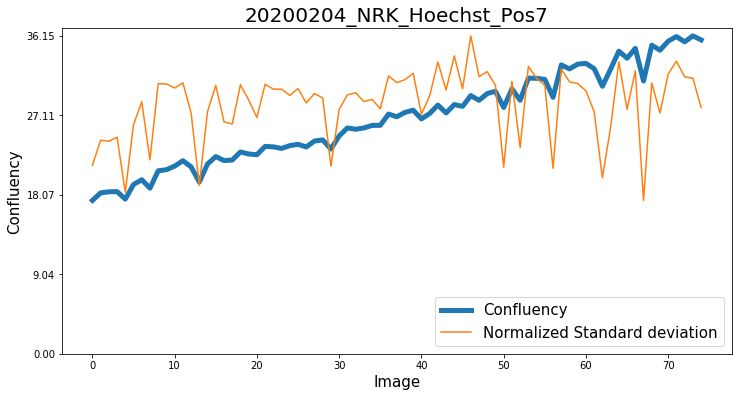

In [320]:
for image_dir in BASE_DIRS:
    
    dir_name = image_dir.split("\\")[-2]
    
    confl, stds = get_image_stats(image_dir, normalize=True)
    
    max_measure = max(max(confl), max(stds))
   
    plt.figure(figsize=(12,6))
    plt.title(f"{dir_name}", fontsize=20)
    plt.plot(confl, label="Confluency", linewidth=5)
    plt.plot(stds, label="Normalized Standard deviation")
    plt.xlabel("Image", fontsize=15)
    plt.ylabel("Confluency", fontsize=15) 
    plt.xticks(fontsize=10) 
    plt.yticks(np.linspace(0, max_measure, num=5), fontsize=10) 
    plt.legend(fontsize=15, loc="lower right")
    plt.show()